In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
import torch.nn.functional as F
import numpy as np
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import librosa
import torch

In [34]:

model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
input_audio, sample_rate = librosa.load(r"audio\hello_intense.wav",  sr=16000)

i= feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)

with torch.no_grad():
  aud1 = model(i.input_values)
print(aud1.keys())
print(aud1.last_hidden_state.shape)
print(aud1.extract_features.shape)

odict_keys(['last_hidden_state', 'extract_features'])
torch.Size([1, 161, 1024])
torch.Size([1, 161, 512])


In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import librosa

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h", output_hidden_states=True)

In [83]:
audio_file_path1 = r"audio\h_orig.wav"
waveform1, sample_rate1 = librosa.load(audio_file_path1, sr=16000)

audio_file_path2 = r"audio\hello_intense.wav"
waveform2, sample_rate2 = librosa.load(audio_file_path2, sr=16000)

# Preprocess the audio
input_values1 = processor(waveform1, return_tensors="pt", sampling_rate=sample_rate1).input_values
input_values2 = processor(waveform2, return_tensors="pt", sampling_rate=sample_rate2).input_values

with torch.no_grad():
    outputs1 = model(input_values1)
    outputs2 = model(input_values2)

# Extract embeddings from the last layer's hidden states

embeddings1 = outputs1.hidden_states[-1].mean(dim=1).numpy()
embeddings2 = outputs2.hidden_states[-1].mean(dim=1).numpy()

print("Embeddings shape for audio file 1:", embeddings1.shape)
print("Embeddings shape for audio file 2:", embeddings2.shape)


Embeddings shape for audio file 1: (1, 768)
Embeddings shape for audio file 2: (1, 768)


In [85]:
from sklearn.metrics.pairwise import cosine_similarity

# Assuming embeddings1 and embeddings2 are the extracted embeddings from your model
# (you can replace this with the actual variable names if they are different)

similarity_matrix = cosine_similarity(embeddings1, embeddings2)
print(similarity_matrix)

[[0.9202887]]


In [61]:
outputs1.logits.mean(dim=1)

tensor([[ 11.4784, -24.7005, -24.4234, -24.5538,   1.1274,  -1.5464,  -1.3108,
          -1.1120,  -1.7210,  -2.9176,  -1.8094,  -1.6121,  -2.2619,  -2.5788,
          -2.9104,  -2.3800,  -2.0078,  -3.9594,  -1.8994,  -5.2190,  -4.6276,
          -3.5659,  -3.4151,  -5.2099,  -4.1115,  -5.2302,  -4.3804,  -3.2029,
          -7.8195,  -6.1227,  -7.5336,  -6.1881]])

In [86]:
import torch.nn.functional as F

# Apply softmax to get probabilities
probs = F.softmax(outputs1.logits, dim=-1)

# Decode using greedy decoding (selecting the token with the highest probability at each step)
predicted_ids = torch.argmax(probs, dim=-1)

# Convert token IDs to text using the processor
transcription = processor.batch_decode(predicted_ids)[0]
print(transcription)

WHOSE WOODS THESE ARE I THINK I KNOW HIS HOUSE IS IN THE VILLAGE THOUGH


In [78]:
probs

tensor([[[1.0000e+00, 9.6135e-18, 1.3346e-17,  ..., 1.4167e-09,
          7.5067e-10, 1.0788e-09],
         [9.9999e-01, 9.8008e-18, 1.3395e-17,  ..., 1.3904e-09,
          7.5357e-10, 1.0617e-09],
         [1.0000e+00, 7.6130e-18, 1.0462e-17,  ..., 1.2493e-09,
          6.3851e-10, 9.4630e-10],
         ...,
         [9.9999e-01, 1.2809e-17, 1.7225e-17,  ..., 1.3493e-09,
          7.1988e-10, 1.6679e-09],
         [9.9998e-01, 1.3496e-17, 1.7287e-17,  ..., 1.4443e-09,
          1.0346e-09, 1.1550e-09],
         [9.9999e-01, 1.4140e-17, 1.8806e-17,  ..., 1.4087e-09,
          8.0750e-10, 1.6381e-09]]])

In [20]:
print(embeddings.logits.shape)

torch.Size([1, 140, 32])


In [10]:
from pydub import AudioSegment
from pydub.playback import play
import numpy as np

# Load audio using pydub
audio = AudioSegment.from_file(r"audio\h_orig.wav")

# Set the target sample rate (e.g., 16 kHz)
target_sr = 16000

# Resample audio to the target sample rate
resampled_audio = audio.set_frame_rate(target_sr)

# Apply a low-pass filter for noise reduction (adjust as needed)
filtered_audio = resampled_audio.low_pass_filter(500)

# Get the array of samples
samples_array = np.array(filtered_audio.get_array_of_samples())

# Reshape the array to (1, 45120)
reshaped_array = samples_array.reshape((1, -1))

# Print the shape of the reshaped array
print(reshaped_array.shape)

# Play the original and filtered audio
play(audio)
play(filtered_audio)


(1, 63999)


In [35]:
# Define audio files to compare
audio_1_path = r"audio\hello_intense.wav"
audio_2_path = r"audio\file.wav"

# Load audio files
input_audio_1, sample_rate_1 = librosa.load(audio_1_path,  sr=16000)
input_audio_2, sample_rate_2 = librosa.load(audio_2_path,  sr=16000)

i_1 = feature_extractor(input_audio_1, return_tensors="pt", sampling_rate=sample_rate)
i_2 = feature_extractor(input_audio_2, return_tensors="pt", sampling_rate=sample_rate)

# Generate speech embeddings
with torch.no_grad():
    output_1 = model(i_1.input_values)
    embedding_1 = output_1.last_hidden_state.mean(dim=1)

    output_2 = model(i_2.input_values)
    embedding_2 = output_2.last_hidden_state.mean(dim=1)



torch.Size([1, 1024]) torch.Size([1, 1024])


In [37]:
cosine_similarity = F.cosine_similarity(embedding_1, embedding_2, dim=1)

print(cosine_similarity.item())

0.9982227087020874


In [40]:
cosine_similarity

tensor([0.9982])

In [28]:
input_audio, sample_rate = librosa.load(r"audio\file.wav",  sr=16000)

i= feature_extractor(input_audio, return_tensors="pt", sampling_rate=sample_rate)

with torch.no_grad():
  aud2 = model(i.input_values)

In [9]:
def mean_pooling_downsample(vector: np.ndarray, factor: int) -> np.ndarray:
    """
    Downsample the input vector using mean pooling.

    Parameters:
    - vector (np.ndarray): Input vector containing values.
    - factor (int): Downsample factor.

    Returns:
    - np.ndarray: Downsampled vector.
    """
    downsampled_vector = np.mean(vector.reshape(-1, factor), axis=1)
    return downsampled_vector

def apply_downsampling_and_pca(vector: np.ndarray, downsample_factor: int) -> np.ndarray:
    """
    Apply downsampling and PCA transformation to the input vector.

    Parameters:
    - vector (np.ndarray): Input vector containing values.
    - downsample_factor (int): Downsample factor.

    Returns:
    - np.ndarray: Downsampled and PCA-transformed vector.
    """
    # Downsample the vector using mean pooling
    downsampled_vector = mean_pooling_downsample(vector, downsample_factor)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=1)
    reduced_vector = pca.fit_transform(downsampled_vector.reshape(-1, 1)).flatten()

    return reduced_vector

def plot_colored_bars(vector: np.ndarray, width: float = 1.0) -> None:
    """
    Plots a bar chart with varying color intensity based on the values in the input vector.

    Parameters:
    - vector (np.ndarray): Input vector containing values for bar heights.
    - width (float): Width of the bars in the bar chart.

    Returns:
    - None
    """
    # Normalize values to [0, 1] for color intensity
    normalized_values = (vector - min(vector)) / (max(vector) - min(vector))

    # Create a colormap with varying intensity
    colors = plt.cm.viridis(normalized_values)

    # Plotting with reduced gap
    plt.bar(range(len(vector)), [1] * len(vector), color=colors, width=width, align='center')

    # Adding labels
    plt.xlabel('Index')
    plt.ylabel('Bars with Different Color Intensity')

    # Show the plot
    plt.show()

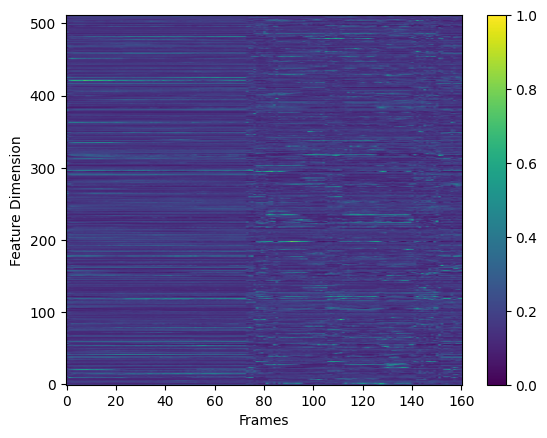

In [21]:
# Assuming extract_features is a torch.Tensor
tensor = aud1.extract_features

# Reshape the tensor for plotting, considering batch size 1
reshaped_tensor = tensor.squeeze(0).numpy()

# Normalize values to [0, 1] for color intensity
normalized_values = (reshaped_tensor - reshaped_tensor.min()) / (reshaped_tensor.max() - reshaped_tensor.min())

# Create a colormap with varying intensity
cmap = plt.cm.viridis

# Plotting 2D heatmap
plt.imshow(normalized_values.T, cmap=cmap, aspect='auto', origin='lower')

# Adding labels
plt.xlabel('Frames')
plt.ylabel('Feature Dimension')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()


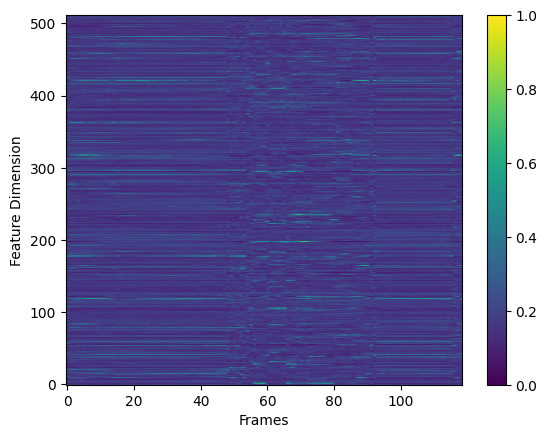

In [25]:
# Assuming extract_features is a torch.Tensor
tensor = aud2.extract_features

# Reshape the tensor for plotting, considering batch size 1
reshaped_tensor = tensor.squeeze(0).numpy()

# Normalize values to [0, 1] for color intensity
normalized_values = (reshaped_tensor - reshaped_tensor.min()) / (reshaped_tensor.max() - reshaped_tensor.min())

# Create a colormap with varying intensity
cmap = plt.cm.viridis

# Plotting 2D heatmap
plt.imshow(normalized_values.T, cmap=cmap, aspect='auto', origin='lower')

# Adding labels
plt.xlabel('Frames')
plt.ylabel('Feature Dimension')

# Show the colorbar
plt.colorbar()

# Show the plot
plt.show()


In [29]:
import torch
import torch.nn.functional as F

# Assuming aud1 and aud2 are instances of Wav2Vec2BaseModelOutput
tensor1 = aud1.last_hidden_state  # Adjust accordingly based on the actual attribute containing the tensor
tensor2 = aud2.last_hidden_state  # Adjust accordingly based on the actual attribute containing the tensor

# Apply mean pooling to align the lengths
tensor1_pooled = F.adaptive_avg_pool2d(tensor1.unsqueeze(0), (1, tensor2.shape[-1])).squeeze(0)
tensor2_pooled = F.adaptive_avg_pool2d(tensor2.unsqueeze(0), (1, tensor1.shape[-1])).squeeze(0)

# Flatten the tensors to make them 2D
tensor1_flat = tensor1_pooled.view(1, -1)
tensor2_flat = tensor2_pooled.view(1, -1)

# Normalize the vectors to have unit length
tensor1_normalized = F.normalize(tensor1_flat, p=2, dim=1)
tensor2_normalized = F.normalize(tensor2_flat, p=2, dim=1)

# Calculate cosine similarity
cosine_similarity = F.cosine_similarity(tensor1_normalized, tensor2_normalized, dim=1)

print(cosine_similarity.item())


0.9982227087020874
